# Day Map Challenge

Este notebook contiene el código para el desafío de mapas.

## Ejecutar en Google Colab

[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lalgonzales/scriptsVarios/blob/main/notebooks/day_map_challenge.ipynb)

# Mapa 13 de noviembre

**A new tool**: Use a tool you’ve never tried before. The challenge has always been about trying new things. Use a tool, software, or drawing technique you’ve never worked with before. 🧪🔧

## Modulos

In [5]:
# plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from highlight_text import fig_text
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text
from pyfonts import load_font
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar

# data
import pandas as pd
import geopandas as gpd
from owslib.wfs import WebFeatureService

## Explorar los datos del geoportal de ICF

In [6]:
# Cargar las capas de datos desde el wfs del ICF

# Crear la conexion al servicio wfs
wfs_url = "http://geoserver.icf.gob.hn/icf/wfs"
wfs = WebFeatureService(url=wfs_url, version="1.1.0")

## Obtener listado de capas disponibles 
capas_disponibles = list(wfs.contents)
for capa in capas_disponibles:
    print(capa)


icf:Limite_HN
icf:Planes_operativos
icf:Red_Via
icf:Titulacion_indigena
icf:adef
icf:alertas_deforestacion
icf:areas_asignadas
icf:areas_proceso_titulacion_y_catastro
icf:areas_protegidas_declarada
icf:areas_protegidas_gp
icf:areas_protegidas_propuesta
icf:caserios
icf:casos_adef
icf:certificado_plantaciones
icf:cppfi
icf:dt_expedient
icf:dt_expediente_preliminar
icf:dt_restriccion_dt_preliminar
icf:fotos_global
icf:honduras_y_sus_mares
icf:limite_adaptarc
icf:m1102va001970_hn
icf:m1103va002001_hn
icf:m1104vA002001_HN
icf:m2301vl001970_hn
icf:m3101vl001970_hn
icf:microcuencas_declaradas
icf:microcuencas_declaradas_111019
icf:n2202va001973_hn
icf:n2303vl000000_hn
icf:n2502va002001_hn
icf:n2503va000000_hn
icf:perdidas_nref
icf:planes_de_manejo_aprobados
icf:planes_de_manejo_historicos
icf:planes_de_salvamento
icf:r1201vl001970_hn
icf:regiones_forestales_icf
icf:reservas_biosfera
icf:reservas_naturales_privadas
icf:test_jva
icf:vida_silvestre


## Obtener las capas de interes del wfs y almacenarlas en un diccionario

In [7]:

# Crear la llamada a las capas de interés
capas_list = ["icf:m1102va001970_hn", "icf:microcuencas_declaradas"]

# Crear los gdf de cada capa
gdf_capas_dict = {}
for capa in capas_list:
    if capa == "icf:m1102va001970_hn":
        capa_name = 'departamentos'
    else:
        capa_name = capa.split(":")[-1]
    response = wfs.getfeature(typename=capa, outputFormat="application/json")
    gdf = gpd.read_file(response)
    gdf_capas_dict[capa_name] = gdf

print(gdf_capas_dict.keys())

dict_keys(['departamentos', 'microcuencas_declaradas'])


## Limpiar y transformar los datos de microcuencas

In [8]:
# Preparar las microcuencas para el mapa
gdf_mc = gdf_capas_dict["microcuencas_declaradas"]
# gdf_mc.dtypes

# Eliminar los registros sin fecha
gdf_mc.dropna(subset=["fech_decl"], inplace=True)
gdf_mc["anio_decla"] = gdf_mc["anio_decla"].astype(int)
 
# Obtener las fechas min y max
fecha_min = gdf_mc["fech_decl"].min()
fecha_max = gdf_mc["fech_decl"].max()

print(fecha_min, fecha_max)
# gdf_mc.fech_decl.unique

# Seleccionar las columnas de interes
gdf_mc = gdf_mc[["id", "anio_decla", "fech_decl", "area_ha", "geometry"]].copy()

# Ordenar los datos por fecha de declaración
gdf_mc = gdf_mc.sort_values(by="fech_decl").reset_index()

# Contar la cantidad de declaraciones por año
decl_by_year = gdf_mc.groupby(by=["anio_decla"])["anio_decla"].size()

# Eliminar 2008 ya que solo tiene 1 declaratoria y la siguientes inician en 2020
gdf_mc_gte_2020 = gdf_mc.query("anio_decla != 2008").copy()
gdf_mc_gte_2020.reset_index()
print(gdf_mc_gte_2020.shape[0], gdf_mc.shape[0])
gdf_mc_gte_2020.head()
# Crear df de area por año y el acumulado por año
df_acumulado = gdf_mc_gte_2020.groupby("anio_decla").agg(area_ha = ("area_ha", "sum")).reset_index()
df_acumulado["area_acc"] = df_acumulado["area_ha"].cumsum()
df_acumulado

2008-02-15 00:00:00 2024-11-13 00:00:00
276 277


,anio_decla,area_ha,area_acc
0,2020,4969.006433,4969.006433
1,2021,5688.960295,10657.966728
2,2022,9538.426864,20196.393592
3,2023,6710.120892,26906.514484
4,2024,3927.659917,30834.174401


In [9]:
# Pasar el gdf a wgs84, EPSG:4326
gdf_wgs64 = gdf_mc_gte_2020.copy()
gdf_wgs64.geometry = gdf_wgs64.geometry.to_crs(epsg=4326)
gdf_wgs64 = gdf_wgs64.explode(ignore_index=True)
gdf_wgs64.head()

,index,id,anio_decla,fech_decl,area_ha,geometry
0,593,microcuencas_declaradas.988,2020,2020-01-10,2816.24641,"POLYGON ((-86.68708 15.11314, -86.68641 15.111..."
1,814,microcuencas_declaradas.1036,2020,2020-01-17,4.92363,"POLYGON ((-88.07897 14.07336, -88.07928 14.073..."
2,409,microcuencas_declaradas.1033,2020,2020-01-29,27.25117,"POLYGON ((-88.42064 14.61149, -88.42192 14.610..."
3,867,microcuencas_declaradas.1044,2020,2020-02-17,211.67794,"POLYGON ((-85.34227 15.34988, -85.34214 15.349..."
4,15,microcuencas_declaradas.17,2020,2020-03-05,17.29032,"POLYGON ((-88.49216 14.22517, -88.49082 14.225..."


## Preparar los datos de limites de departamentos

In [10]:
hn = gdf_capas_dict["departamentos"]
if hn.crs != 4326:
    hn.geometry = hn.geometry.to_crs(4326)
hn.head()

,id,gid,cod,depto,shape_leng,shape_area,dep,codpais,km2,densidad,geometry
0,m1102va001970_hn.fid--219abc1e_19325763f09_3723,2,03,Comayagua,482034.509535,5.120776e+09,3,HN,5120.78,64.8952,"MULTIPOLYGON (((-87.33114 14.63221, -87.33114 ..."
1,m1102va001970_hn.fid--219abc1e_19325763f09_3724,7,12,La Paz,332840.617570,2.534509e+09,12,HN,2534.51,58.3099,"MULTIPOLYGON (((-87.94295 14.38363, -87.94291 ..."
2,m1102va001970_hn.fid--219abc1e_19325763f09_3725,8,13,Lempira,435532.949242,4.285705e+09,13,HN,4285.70,56.9267,"MULTIPOLYGON (((-88.50195 14.44268, -88.50142 ..."
3,m1102va001970_hn.fid--219abc1e_19325763f09_3726,10,15,Olancho,799056.149961,2.399735e+10,15,HN,23997.40,16.0385,"MULTIPOLYGON (((-86.72937 14.49676, -86.72922 ..."
4,m1102va001970_hn.fid--219abc1e_19325763f09_3727,11,18,Yoro,697349.674892,7.827900e+09,18,HN,7827.90,56.2387,"MULTIPOLYGON (((-86.72227 15.56543, -86.71926 ..."


## Crear el mapa

In [ ]:
hn.total_bounds

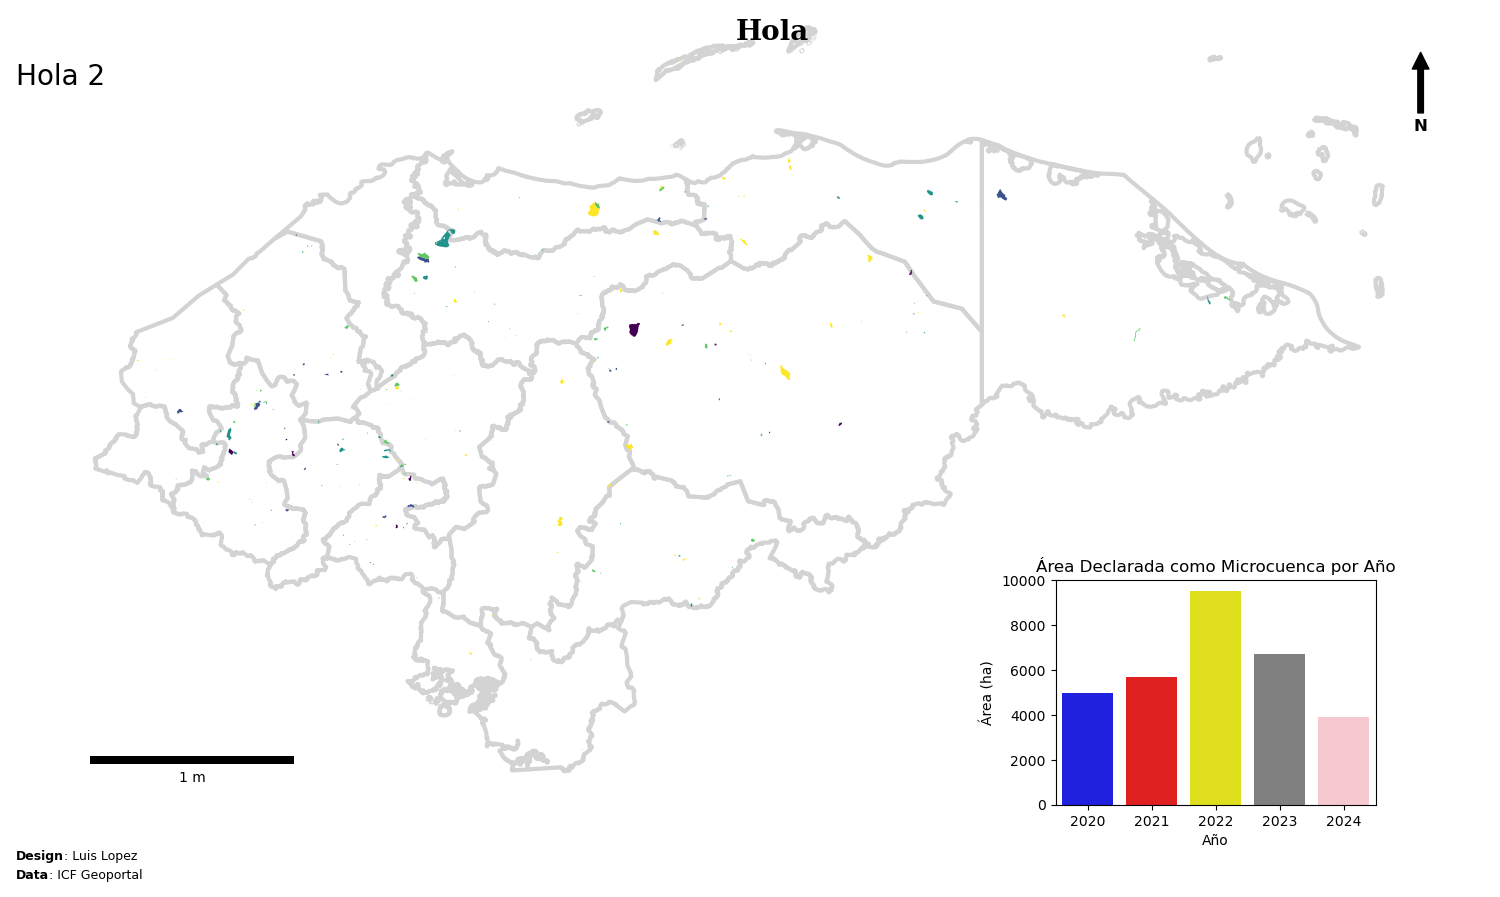

In [17]:
# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Crear el plot para los limites de departamentos
hn.plot(ax=ax, column="depto", edgecolor="lightgrey", linewidth=3, facecolor="none")

# Agregar las microcuendas y dar color por los anios
gdf_wgs64.plot(ax=ax, column="anio_decla")

# custom axis
ax.set_xlim(-89.4, -82.5)
ax.set_ylim(12.9, 16.6)
ax.axis("off")

# Agregar titulo
year = 2024
fig.text(
    0.5,
    0.95,
    'Hola',
    fontsize=20,
    fontweight='bold',
    fontfamily='serif'
)
fig.text(0.05, 0.9, 'Hola 2', fontsize=20)

# Agregar créditos 
text = "<Design>: Luis Lopez\n<Data>: ICF Geoportal"
fig_text(0.05, 0.05, s=text,
         color='black',
         fontsize=9,
         highlight_textprops=[{"fontweight": 'bold'},
                              {"fontweight": 'bold'}],
         ax=ax)

# Barplot
mini_ax = ax.inset_axes(bounds=(0.7, 0.1, 0.20, 0.25), transform=fig.transFigure)
# mini_ax.axis("off")
sns.barplot(
    data=df_acumulado,
    x="anio_decla",
    y="area_ha",
    palette=["blue", "red", "yellow", "gray", "pink"],
    ax=mini_ax,
    hue="anio_decla",
    legend=False    
)

# Personalizar el bar plot
mini_ax.set_title('Área Declarada como Microcuenca por Año')
mini_ax.set_xlabel('Año')
mini_ax.set_ylabel('Área (ha)')
# mini_ax.invert_yaxis()

# Agregar la rosa náutica
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', va='center', fontsize=12, fontweight='bold',
             xycoords=ax.transAxes)

# Agregar la escala
scalebar = ScaleBar(1, units='m', dimension='si-length', location='lower left')
ax.add_artist(scalebar)

# display the plot
plt.tight_layout()
plt.show()